In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost

## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

In [2]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [4]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [5]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [6]:
cl_ids_test

array([ 5182,  3855,  2980,  9456,  8295,  5327,  6422,  9708,  7301,
        9656,  5778,  3478,  4393,  5976,  5657,  3973,  4737,   390,
        9365,  8234,  3092,  6624,  9446,  9632,  1794,  4406,  1147,
        2055,  2678,  9734,  4123,  1550,    11,  4277,  9880,  9675,
         235,  1133,   160,   506,  4400,   477,  6639,  3264,  2179,
        1448,  8550,  8064,  2702,  1898,  4486,   402,  8103,  5091,
        8766,  9524,  8366,  5231,  7727,  9017,  6278,  9780,  9143,
        6683,   373,  2215,  1113,  6818,   325,  5243,  1919,  6079,
        2871,  3601,  7690,  2362,  7572,    96,  1430,  4838,  1065,
        8983,  4917,  5032,  3424,   756,  6326,  1620,   196,  5055,
        9813,  1265,   106,  2883,  5304,  1849,   528,  5237,  6281,
        7821,  7840,  5977,  9249, 10095,  2665,  1076,  8260,  8374,
        9330,  2188,  8727,  2233,  8892,  3656,  6811,  7486,  4766,
        7252,   204,   531,  5601,  4828,  6043,  3527,  4602,  9792,
        4296,  5516,

## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
5. **Дополнительная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
6. Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части

При возникновении вопросов и для отправки домашнего задания - ks.gusev@physics.msu.ru
    

## Практика

In [7]:
raw_df.describe()

,cl_id,MCC,currency,amount,target_flag,target_sum
count,490513.000000,490513.000000,490513.000000,4.905130e+05,490513.000000,4.905130e+05
mean,4802.127361,5699.783822,810.601854,5.723594e+03,0.652588,1.627345e+05
std,2986.492835,662.933380,38.223123,7.703763e+04,0.476148,1.474097e+06
min,0.000000,742.000000,32.000000,4.000000e-02,0.000000,0.000000e+00
25%,2193.000000,5411.000000,810.000000,2.240000e+02,0.000000,0.000000e+00
50%,4576.000000,5661.000000,810.000000,6.240000e+02,1.000000,2.491009e+04
75%,7390.000000,5941.000000,810.000000,2.176000e+03,1.000000,1.516193e+05
max,10215.000000,9405.000000,986.000000,3.583500e+07,1.000000,4.606578e+07


In [8]:
# посмотрим на статистики для категориальных значений 
raw_df.describe(include=['object'])

,PERIOD,channel_type,TRDATETIME,trx_category
count,490513,487603,490513,490513
unique,19,5,58113,10
top,01/07/2017,type1,23JUN17:00:00:00,POS
freq,55757,299247,1971,416425


In [9]:
# посмотрим на MCC как на категорию
print('mode', raw_df['MCC'].mode())

print('unique', len(raw_df.MCC.unique()))

# это категория 	Бакалейные магазины, супермаркеты

#Источник: https://mcc-codes.ru/code

mode 0    5411
dtype: int64
unique 344


In [10]:
# посмотрим на currency как на категорию
print('mode', raw_df['currency'].mode())

print('unique', len(raw_df.currency.unique()))

# 810 - это рубль

mode 0    810
dtype: int64
unique 59


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022B00025CF8>,
      dtype=object)

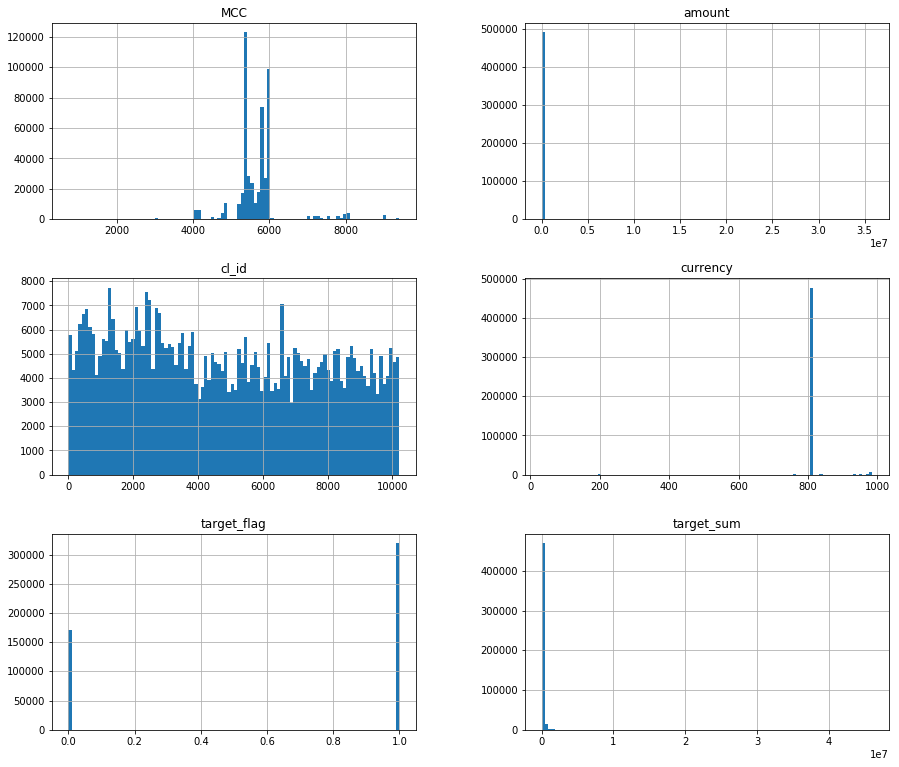

In [11]:

raw_df.hist(bins=100, figsize=(15,13))

In [12]:
import seaborn as sns

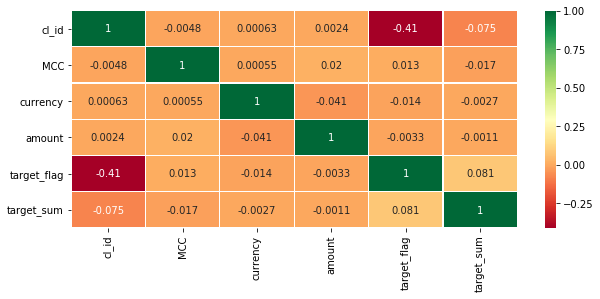

In [13]:
sns.heatmap(raw_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,4)
plt.show()

In [ ]:
# есть небольшая отриц корр по cl_id. 
# т.к. cl_id присваивается в хронологиеском порядке.
# то, что клиент с нами больше 3-х месяцев неизвестно для недавно подключившихся клиентов
# отсюда и корреляция

In [14]:
def missingdata(raw_df):
    '''
    считаем кол-во и долю пропущеных значений
    '''
    total = raw_df.isnull().sum().sort_values(ascending = False)
    percent = (raw_df.isnull().sum()/raw_df.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    return ms

In [15]:
missingdata(raw_df)

,Total,Percent
channel_type,2910,0.593256


In [16]:
t_channel = raw_df.groupby(['channel_type']).count()['target_flag'].reset_index()

t_channel['percent'] = t_channel['target_flag'] / raw_df['channel_type'].count() *100

print(t_channel)

  channel_type  target_flag    percent
0        type1       299247  61.371033
1        type2       175013  35.892519
2        type3         3280   0.672678
3        type4         4476   0.917960
4        type5         5587   1.145809


In [17]:
# смотрим как распределены пропуски по целевой переменной
raw_df[raw_df.channel_type.isnull()].groupby('target_flag').count()['currency']

# примерно 50/50

target_flag
0    1627
1    1283
Name: currency, dtype: int64

In [18]:
channel_target = raw_df.groupby(['channel_type', 'target_flag']).count()['currency']
channel_target

channel_type  target_flag
type1         0              145779
              1              153468
type2         0               19717
              1              155296
type3         0                1017
              1                2263
type4         0                1026
              1                3450
type5         0                1244
              1                4343
Name: currency, dtype: int64

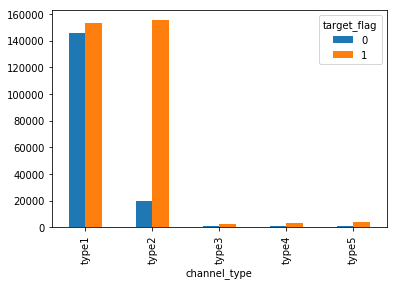

In [19]:
# видим, что для type1 кол-во отказов к продолжению 50/50
channel_target.unstack().plot(kind='bar')

#### type1 это так же мода, поэтому пропуски можно заполнить этим значением

In [20]:
raw_df['channel_type'].fillna(raw_df['channel_type'].mode()[0], inplace = True)

In [21]:
missingdata(raw_df)

,Total,Percent


#### type2 имеет значительно меньшее кол-во отказов по сравнению с type1.
Принадлежность к type2 снижает вероятность отказа по сравнению к 1
также видно 3 группы по частоте появления type: type1, type2 и type3-5
Преобразуем данный категориальный атрибут в частотный

In [22]:
prob_type = (raw_df[raw_df['target_flag'] == 1]['channel_type'].value_counts())/(raw_df['channel_type'].value_counts())

In [23]:
prob_type

type1    0.512154
type2    0.887340
type3    0.689939
type4    0.770777
type5    0.777340
Name: channel_type, dtype: float64

In [24]:
def channel_cat(data):
    '''
    заполняем значения popular MCC
    '''
    if data == 'type1':
        return prob_type[0]
    elif data == 'type2': 
        return prob_type[1]
    elif data == 'type3':
        return prob_type[2]
    elif data == 'type4':
        return prob_type[3]
    elif data == 'type5':
        return prob_type[4]
    else:
        return 0

In [25]:
raw_df['channel_type_new'] = raw_df['channel_type'].apply(channel_cat)

In [26]:
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,channel_type_new
0,01/10/2017,0,5200,type1,810,21OCT17:00:00:00,5023.0,POS,0,0.0,0.512154
1,01/10/2017,0,6011,type1,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,0.512154
2,01/12/2017,0,5921,type1,810,05DEC17:00:00:00,767.0,POS,0,0.0,0.512154
3,01/10/2017,0,5411,type1,810,21OCT17:00:00:00,2031.0,POS,0,0.0,0.512154
4,01/10/2017,0,6012,type1,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0,0.512154


In [27]:
missingdata(raw_df)

,Total,Percent


In [ ]:
#MCC

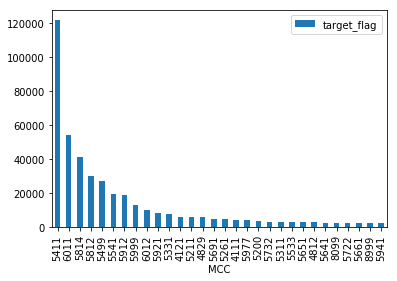

In [28]:
raw_df.groupby(['MCC']).count()[['target_flag']].sort_values('target_flag', ascending=False).head(30).plot(kind='bar')

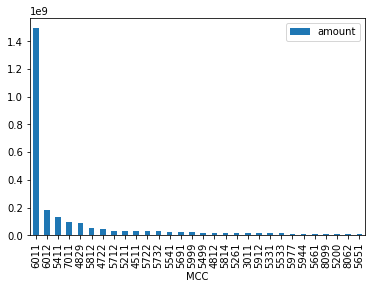

In [29]:
raw_df.groupby(['MCC']).sum()[['amount']].sort_values('amount', ascending=False).head(30).plot(kind='bar')

Сравним группировки по ко-ву и по сумме
Выделим 5 лидеров в каждой группе
1 - 5411 / 6011
2 - 6011 / 6012
3 - 5814 / 5411
4 - 5812  / 7011
5 - 5499 / 4829

Источник: https://mcc-codes.ru/code

Предположим, что те кто будет пользоваться услугами банка должны сразу использовать карту для повседневных расходов, а также для , если расчитываются картой в супермаркетах (5411), ресторанах (5812), снимают наличные в банкоматах (6011)
А также на путешествия (7011 - отели)



In [30]:
MCC_target = raw_df[(raw_df['MCC'] == 5411)].groupby(['target_flag']).count()['currency']
MCC_target


target_flag
0    46297
1    75343
Name: currency, dtype: int64

In [31]:
def mcc_cat(data):
    '''
    заполняем значения popular MCC
    '''
    if data == 6011:
        return 6011
    elif data == 5812: 
        return 5812
    elif data == 7011:
        return 7011
    elif data == 5411:
        return 5411
    else:
        return 7000

In [32]:
raw_df['MCC_new'] = raw_df['MCC'].apply(mcc_cat)

In [33]:

raw_df = pd.get_dummies(raw_df, columns = ["MCC_new"],prefix=["MCC_new"])

raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,channel_type_new,MCC_new_5411,MCC_new_5812,MCC_new_6011,MCC_new_7000,MCC_new_7011
0,01/10/2017,0,5200,type1,810,21OCT17:00:00:00,5023.0,POS,0,0.0,0.512154,0,0,0,1,0
1,01/10/2017,0,6011,type1,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,0.512154,0,0,1,0,0
2,01/12/2017,0,5921,type1,810,05DEC17:00:00:00,767.0,POS,0,0.0,0.512154,0,0,0,1,0
3,01/10/2017,0,5411,type1,810,21OCT17:00:00:00,2031.0,POS,0,0.0,0.512154,1,0,0,0,0
4,01/10/2017,0,6012,type1,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0,0.512154,0,0,0,1,0


In [50]:
summa = raw_df['amount'].sum()

t_amount = raw_df.groupby(['target_flag']).sum()['amount'].reset_index()

counts_0 = len(raw_df[(raw_df['target_flag'] == 0)].cl_id.unique())
counts_1 = len(raw_df[(raw_df['target_flag'] == 1)].cl_id.unique())

t_amount['percent'] = t_amount['amount'] / summa * 100

print(t_amount)

print('per_0', (t_amount['amount'][0] / counts_0))

print('per_1', (t_amount['amount'][1] / counts_1))



   target_flag        amount    percent
0            0  1.035375e+09  36.878945
1            1  1.772122e+09  63.121055
per_0 463670.1527765274
per_1 640448.8761113281


In [51]:
# от суммы трат также есть зависимость
# масштабируем amount

In [53]:
from sklearn import preprocessing

scaler_amount = preprocessing.MinMaxScaler(feature_range=[0, 1])
raw_df['amount_m'] = scaler_amount.fit_transform(raw_df[['amount']])

In [54]:
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,channel_type_new,MCC_new_5411,MCC_new_5812,MCC_new_6011,MCC_new_7000,MCC_new_7011,amount_m
0,01/10/2017,0,5200,type1,810,21OCT17:00:00:00,5023.0,POS,0,0.0,0.512154,0,0,0,1,0,0.000140
1,01/10/2017,0,6011,type1,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0,0.512154,0,0,1,0,0,0.000558
2,01/12/2017,0,5921,type1,810,05DEC17:00:00:00,767.0,POS,0,0.0,0.512154,0,0,0,1,0,0.000021
3,01/10/2017,0,5411,type1,810,21OCT17:00:00:00,2031.0,POS,0,0.0,0.512154,1,0,0,0,0,0.000057
4,01/10/2017,0,6012,type1,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0,0.512154,0,0,0,1,0,0.001020


In [56]:
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'day_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df
    
    

def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H')
    ) 
    return dataset.groupby(
        ['cl_id','hour_of_transaction']
    )['hour_of_transaction'].size().unstack().fillna(0).reset_index()



In [57]:
day_=transaction_by_day_count(raw_df)

In [58]:
day_.tail()

day_of_transaction,cl_id,day_0,day_1,day_2,day_3,day_4,day_5,day_6
4995,10210,16.0,15.0,16.0,31.0,13.0,10.0,13.0
4996,10212,0.0,1.0,2.0,2.0,9.0,0.0,0.0
4997,10213,6.0,13.0,13.0,14.0,15.0,10.0,3.0
4998,10214,15.0,15.0,14.0,7.0,9.0,15.0,32.0
4999,10215,0.0,1.0,7.0,2.0,3.0,9.0,2.0


In [59]:
hour_ =transaction_by_hour_count(raw_df)

In [60]:
hour_.head()

hour_of_transaction,cl_id,00,01,02,03,04,05,06,07,08,...,14,15,16,17,18,19,20,21,22,23
0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
2,5,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,4.0,5.0,2.0,0.0,0.0,0.0,0.0
3,9,7.0,1.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,3.0
4,10,299.0,3.0,6.0,8.0,14.0,9.0,19.0,17.0,13.0,...,6.0,3.0,4.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0


In [61]:
hour_.sum()[['00', '01', '02', '03', '04', '05', '06', '07', '08',
            '09', '10', '11', '12', '13', '14', '15', '16',
            '17', '18', '19', '20', '21', '22', '23']].sort_values(ascending = False )

hour_of_transaction
00    432913.0
13      4843.0
12      4707.0
11      4681.0
14      4397.0
15      4120.0
10      4088.0
16      3848.0
17      3816.0
18      3659.0
09      3635.0
19      2704.0
08      2699.0
07      1983.0
20      1797.0
06      1315.0
21      1268.0
05       981.0
22       850.0
04       660.0
23       491.0
03       456.0
02       350.0
01       252.0
dtype: float64

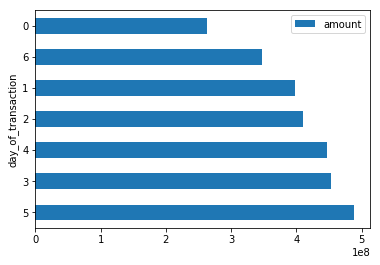

In [62]:
raw_df.groupby(['day_of_transaction']).sum()[['amount']].sort_values('amount', ascending = False ).plot(kind = 'barh')

In [63]:
a = '12OCT17:12:24:07'
date_datetime = datetime.datetime.strptime(a, '%d%b%y:%H:%M:%S' )

In [64]:
date_datetime.strftime('%w')
# действительно четверг
# day_0 - sunday

'4'

#### ожидаемо в пятницу больше всего активности, в воскресенье - меньше всего

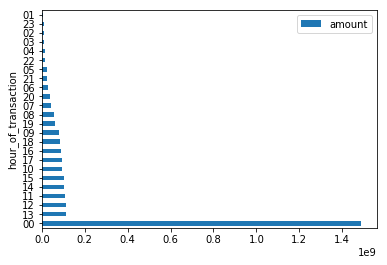

In [65]:
raw_df.groupby(['hour_of_transaction']).sum()[['amount']].sort_values('amount', ascending = False ).plot(kind = 'barh')

#### есть перекос в данных по времени 00, скорее всего это алгоритм банка. В таком виде данная переменная не информативна

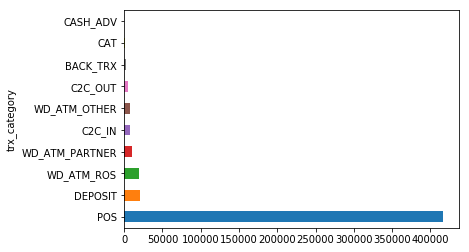

In [66]:
raw_df.groupby(['trx_category']).count()['cl_id'].sort_values(ascending = False).plot(kind = 'barh')

#### есть дисбаланс классов по количеству для POS, посмотрим по сумме

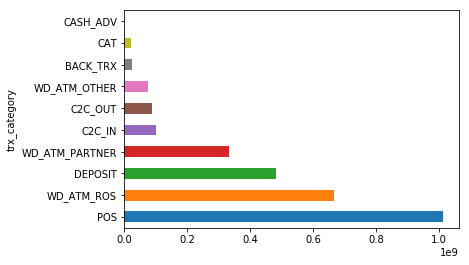

In [67]:
raw_df.groupby(['trx_category']).sum()['amount'].sort_values(ascending = False).plot(kind = 'barh')

стало лучше, также посмотрим вероятности по суммам

In [ ]:
# посмотрим на комплексную вероятность

In [68]:
prob_trx_dict = ((raw_df[raw_df['target_flag'] == 1]['trx_category'].value_counts() / raw_df['trx_category'].value_counts()) *
                  (raw_df.groupby(['trx_category']).sum()['amount'] / raw_df['amount'].sum())).to_dict()

In [69]:
prob_trx_dict

{'BACK_TRX': 0.005169417458437598,
 'C2C_IN': 0.01931066566220388,
 'C2C_OUT': 0.021102036986378015,
 'CASH_ADV': 0.00017213203710488904,
 'CAT': 0.0060331247194159296,
 'DEPOSIT': 0.08023630149814298,
 'POS': 0.23655801034642726,
 'WD_ATM_OTHER': 0.02375979709219387,
 'WD_ATM_PARTNER': 0.08452267178829612,
 'WD_ATM_ROS': 0.16950480361812068}

In [70]:
raw_df['trx_category_new'] = raw_df['trx_category'].apply(prob_trx_dict.get)

In [71]:
drop_column = ['MCC', 'channel_type', 'trx_category', 'target_sum','hour_of_transaction', 'PERIOD', 'TRDATETIME']
raw_df.drop(drop_column, axis=1, inplace = True)

In [72]:
raw_df.drop('day_of_transaction', axis=1, inplace = True)
raw_df.head()

,cl_id,currency,amount,target_flag,channel_type_new,MCC_new_5411,MCC_new_5812,MCC_new_6011,MCC_new_7000,MCC_new_7011,amount_m,trx_category_new
0,0,810,5023.0,0,0.512154,0,0,0,1,0,0.000140,0.236558
1,0,810,20000.0,0,0.512154,0,0,1,0,0,0.000558,0.080236
2,0,810,767.0,0,0.512154,0,0,0,1,0,0.000021,0.236558
3,0,810,2031.0,0,0.512154,1,0,0,0,0,0.000057,0.236558
4,0,810,36562.0,0,0.512154,0,0,0,1,0,0.001020,0.021102


In [74]:
raw_df.drop('MCC_new_7000', axis=1, inplace = True)
raw_df.head()

,cl_id,currency,amount,target_flag,channel_type_new,MCC_new_5411,MCC_new_5812,MCC_new_6011,MCC_new_7011,amount_m,trx_category_new
0,0,810,5023.0,0,0.512154,0,0,0,0,0.000140,0.236558
1,0,810,20000.0,0,0.512154,0,0,1,0,0.000558,0.080236
2,0,810,767.0,0,0.512154,0,0,0,0,0.000021,0.236558
3,0,810,2031.0,0,0.512154,1,0,0,0,0.000057,0.236558
4,0,810,36562.0,0,0.512154,0,0,0,0,0.001020,0.021102


In [75]:
missingdata(raw_df)

,Total,Percent


In [76]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  395219
Total transactions in test dataset:  95294


In [77]:
transactions_train.head()

,cl_id,currency,amount,target_flag,channel_type_new,MCC_new_5411,MCC_new_5812,MCC_new_6011,MCC_new_7011,amount_m,trx_category_new
0,0,810,5023.0,0,0.512154,0,0,0,0,0.000140,0.236558
1,0,810,20000.0,0,0.512154,0,0,1,0,0.000558,0.080236
2,0,810,767.0,0,0.512154,0,0,0,0,0.000021,0.236558
3,0,810,2031.0,0,0.512154,1,0,0,0,0.000057,0.236558
4,0,810,36562.0,0,0.512154,0,0,0,0,0.001020,0.021102


In [78]:
train_columns = [
            'amount_m',
            'channel_type_new',
            'MCC_new_5411',
            'MCC_new_5812',
            'MCC_new_6011',
            'MCC_new_7011',
            'trx_category_new',]
    
x_train = transactions_train[train_columns]
y_train = transactions_train['target_flag']
x_test = transactions_test[train_columns]
y_test = transactions_test['target_flag']

In [79]:
x_train.head()

,amount_m,channel_type_new,MCC_new_5411,MCC_new_5812,MCC_new_6011,MCC_new_7011,trx_category_new
0,0.000140,0.512154,0,0,0,0,0.236558
1,0.000558,0.512154,0,0,1,0,0.080236
2,0.000021,0.512154,0,0,0,0,0.236558
3,0.000057,0.512154,1,0,0,0,0.236558
4,0.001020,0.512154,0,0,0,0,0.021102


In [80]:
xgb = xgboost.XGBClassifier(max_depth=10, n_jobs=-1)

xgb.fit(x_train, y_train)
y_train_predict = xgb.predict_proba(x_train)[:, 1]
y_test_predict = xgb.predict_proba(x_test)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.75
Test:  0.71


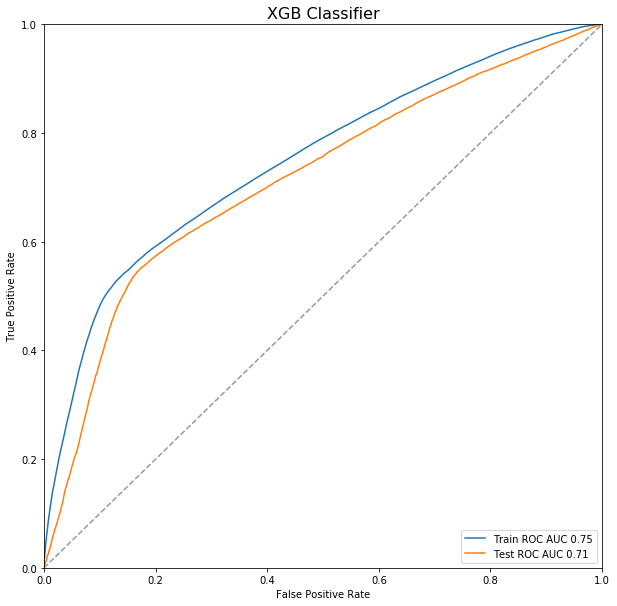

In [81]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

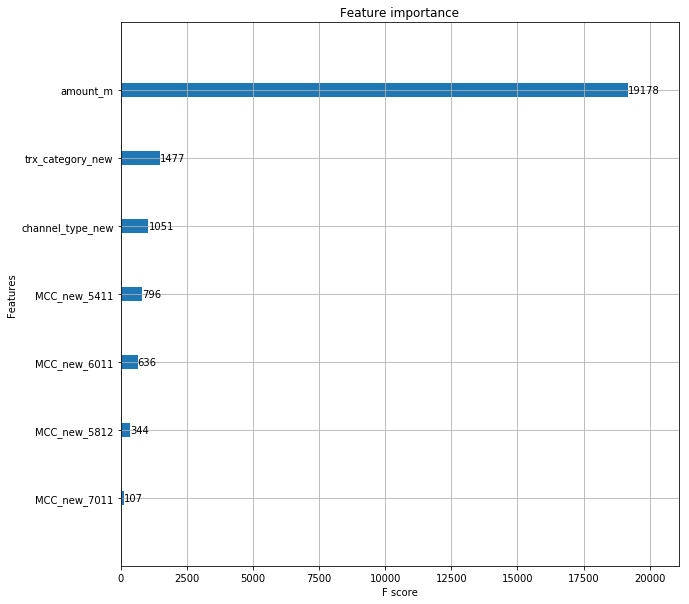

In [82]:
plt.rcParams['figure.figsize'] = (10, 10)
xgboost.plot_importance(booster=xgb)
plt.savefig('tree_importance_test1.png')